In [12]:
require 'loadcaffe'
require 'image'
prototxt = '../../Data/VGG_caffe/VGG_ILSVRC_16_layers_deploy.prototxt'
binary = '../../Data/VGG_caffe/VGG_ILSVRC_16_layers.caffemodel'

-- this will load the network and print it's structure
net = loadcaffe.load(prototxt, binary);
print(net:__tostring())

Successfully loaded ../../Data/VGG_caffe/VGG_ILSVRC_16_layers.caffemodel


conv1_1: 64 3 3 3
conv1_2: 64 64 3 3
conv2_1: 128 64 3 3


conv2_2: 128 128 3 3
conv3_1: 256 128 3 3


conv3_2: 256 256 3 3
conv3_3: 256 256 3 3
conv4_1: 512 256 3 3
conv4_2: 512 512 3 3
conv4_3: 512 512 3 3
conv5_1: 512 512 3 3
conv5_2: 512 512 3 3
conv5_3: 512 512 3 3
fc6: 1 1 25088 4096


fc7: 1 1 4096 4096


fc8: 1 1 4096 1000


nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> (12) -> (13) -> (14) -> (15) -> (16) -> (17) -> (18) -> (19) -> (20) -> (21) -> (22) -> (23) -> (24) -> (25) -> (26) -> (27) -> (28) -> (29) -> (30) -> (31) -> (32) -> (33) -> (34) -> (35) -> (36) -> (37) -> (38) -> (39) -> (40) -> output]
  (1): nn.SpatialConvolution(3 -> 64, 3x3, 1,1, 1,1)
  (2): nn.ReLU
  (3): nn.SpatialConvolution(64 -> 64, 3x3, 1,1, 1,1)
  (4): nn.ReLU
  (5): nn.SpatialMaxPooling(2,2,2,2)
  (6): nn.SpatialConvolution(64 -> 128, 3x3, 1,1, 1,1)
  (7): nn.ReLU
  (8): nn.SpatialConvolution(128 -> 128, 3x3, 1,1, 1,1)
  (9): nn.ReLU
  (10): nn.SpatialMaxPooling(2,2,2,2)
  (11): nn.SpatialConvolution(128 -> 256, 3x3, 1,1, 1,1)
  (12): nn.ReLU
  (13): nn.SpatialConvolution(256 -> 256, 3x3, 1,1, 1,1)
  (14): nn.ReLU
  (15): nn.SpatialConvolution(256 -> 256, 3x3, 1,1, 1,1)
  (16): nn.ReLU
  (17): nn.SpatialMaxPooling(2,2,2,2)
  (18): nn.SpatialConvolution(256 -> 512, 3

In [13]:
-- Loads the mapping from net outputs to human readable labels
function load_synset()
  local list = {}
  for line in io.lines'synset_words.txt' do
    table.insert(list, string.sub(line,11))
  end
  return list
end

function preprocess(img) 
--16 layer VGG expects a 3x224x224 sized image
  img = image.scale(img, 224, 224)
-- Directly obtained from the website
  local mean_pixel = torch.DoubleTensor({103.939, 116.779, 123.68})
-- Permuting from RBG to BGR
  local perm = torch.LongTensor{3, 2, 1}
-- Scaling the elements from 0:1 to 0:256
  img = img:index(1, perm):mul(256.0)
  mean_pixel = mean_pixel:view(3, 1, 1):expandAs(img)
-- Subtracting the mean
  img:add(-1, mean_pixel)
  return img
end

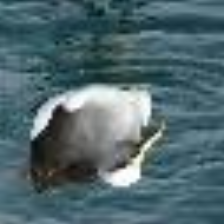

In [34]:
image_name = '../../Data/tiny-imagenet-200/test/images/test_4.JPEG'
im1 = image.load(image_name)
image.rotate(im,im1,3.14159) -- Try rotating the image
-- Try convolving with a smoothing filter 
-- conv_kernel = torch.ones(3,3)/9;
-- print(conv_kernel)
-- im = image.convolve(im,im1,conv_kernel,'full')
itorch.image(image.scale(im, 224, 224)) -- rescale just to show the image-- displaying the image


In [35]:
-- Some trials with tensors
b=torch.ones(3,4)

In [36]:
im = preprocess(im)
prob,classes = net:forward(im):view(-1):sort(true) -- forward pass > resize to a single column > sort

In [37]:

synset_words = load_synset()

for i=1,5 do
  print('predicted class '..tostring(i)..': ', synset_words[classes[i]])
end

predicted class 1: 	killer whale, killer, orca, grampus, sea wolf, Orcinus orca	
predicted class 2: 	albatross, mollymawk	
predicted class 3: 	ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus	
predicted class 4: 	otter	
predicted class 5: 	weasel	


  64
 112
 112
[torch.LongStorage of size 3]



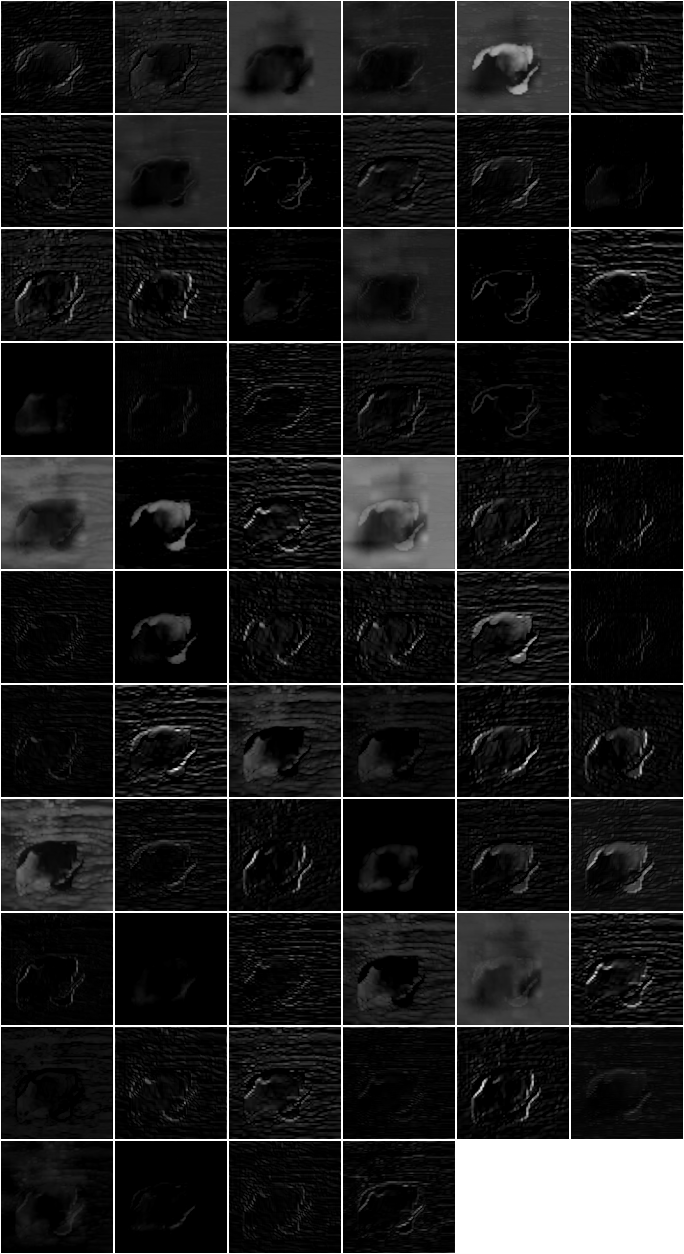

In [38]:
-- Accessing intermediate layers

layer_1 = net.modules[5].output
print(layer_1:size())
itorch.image(layer_1)

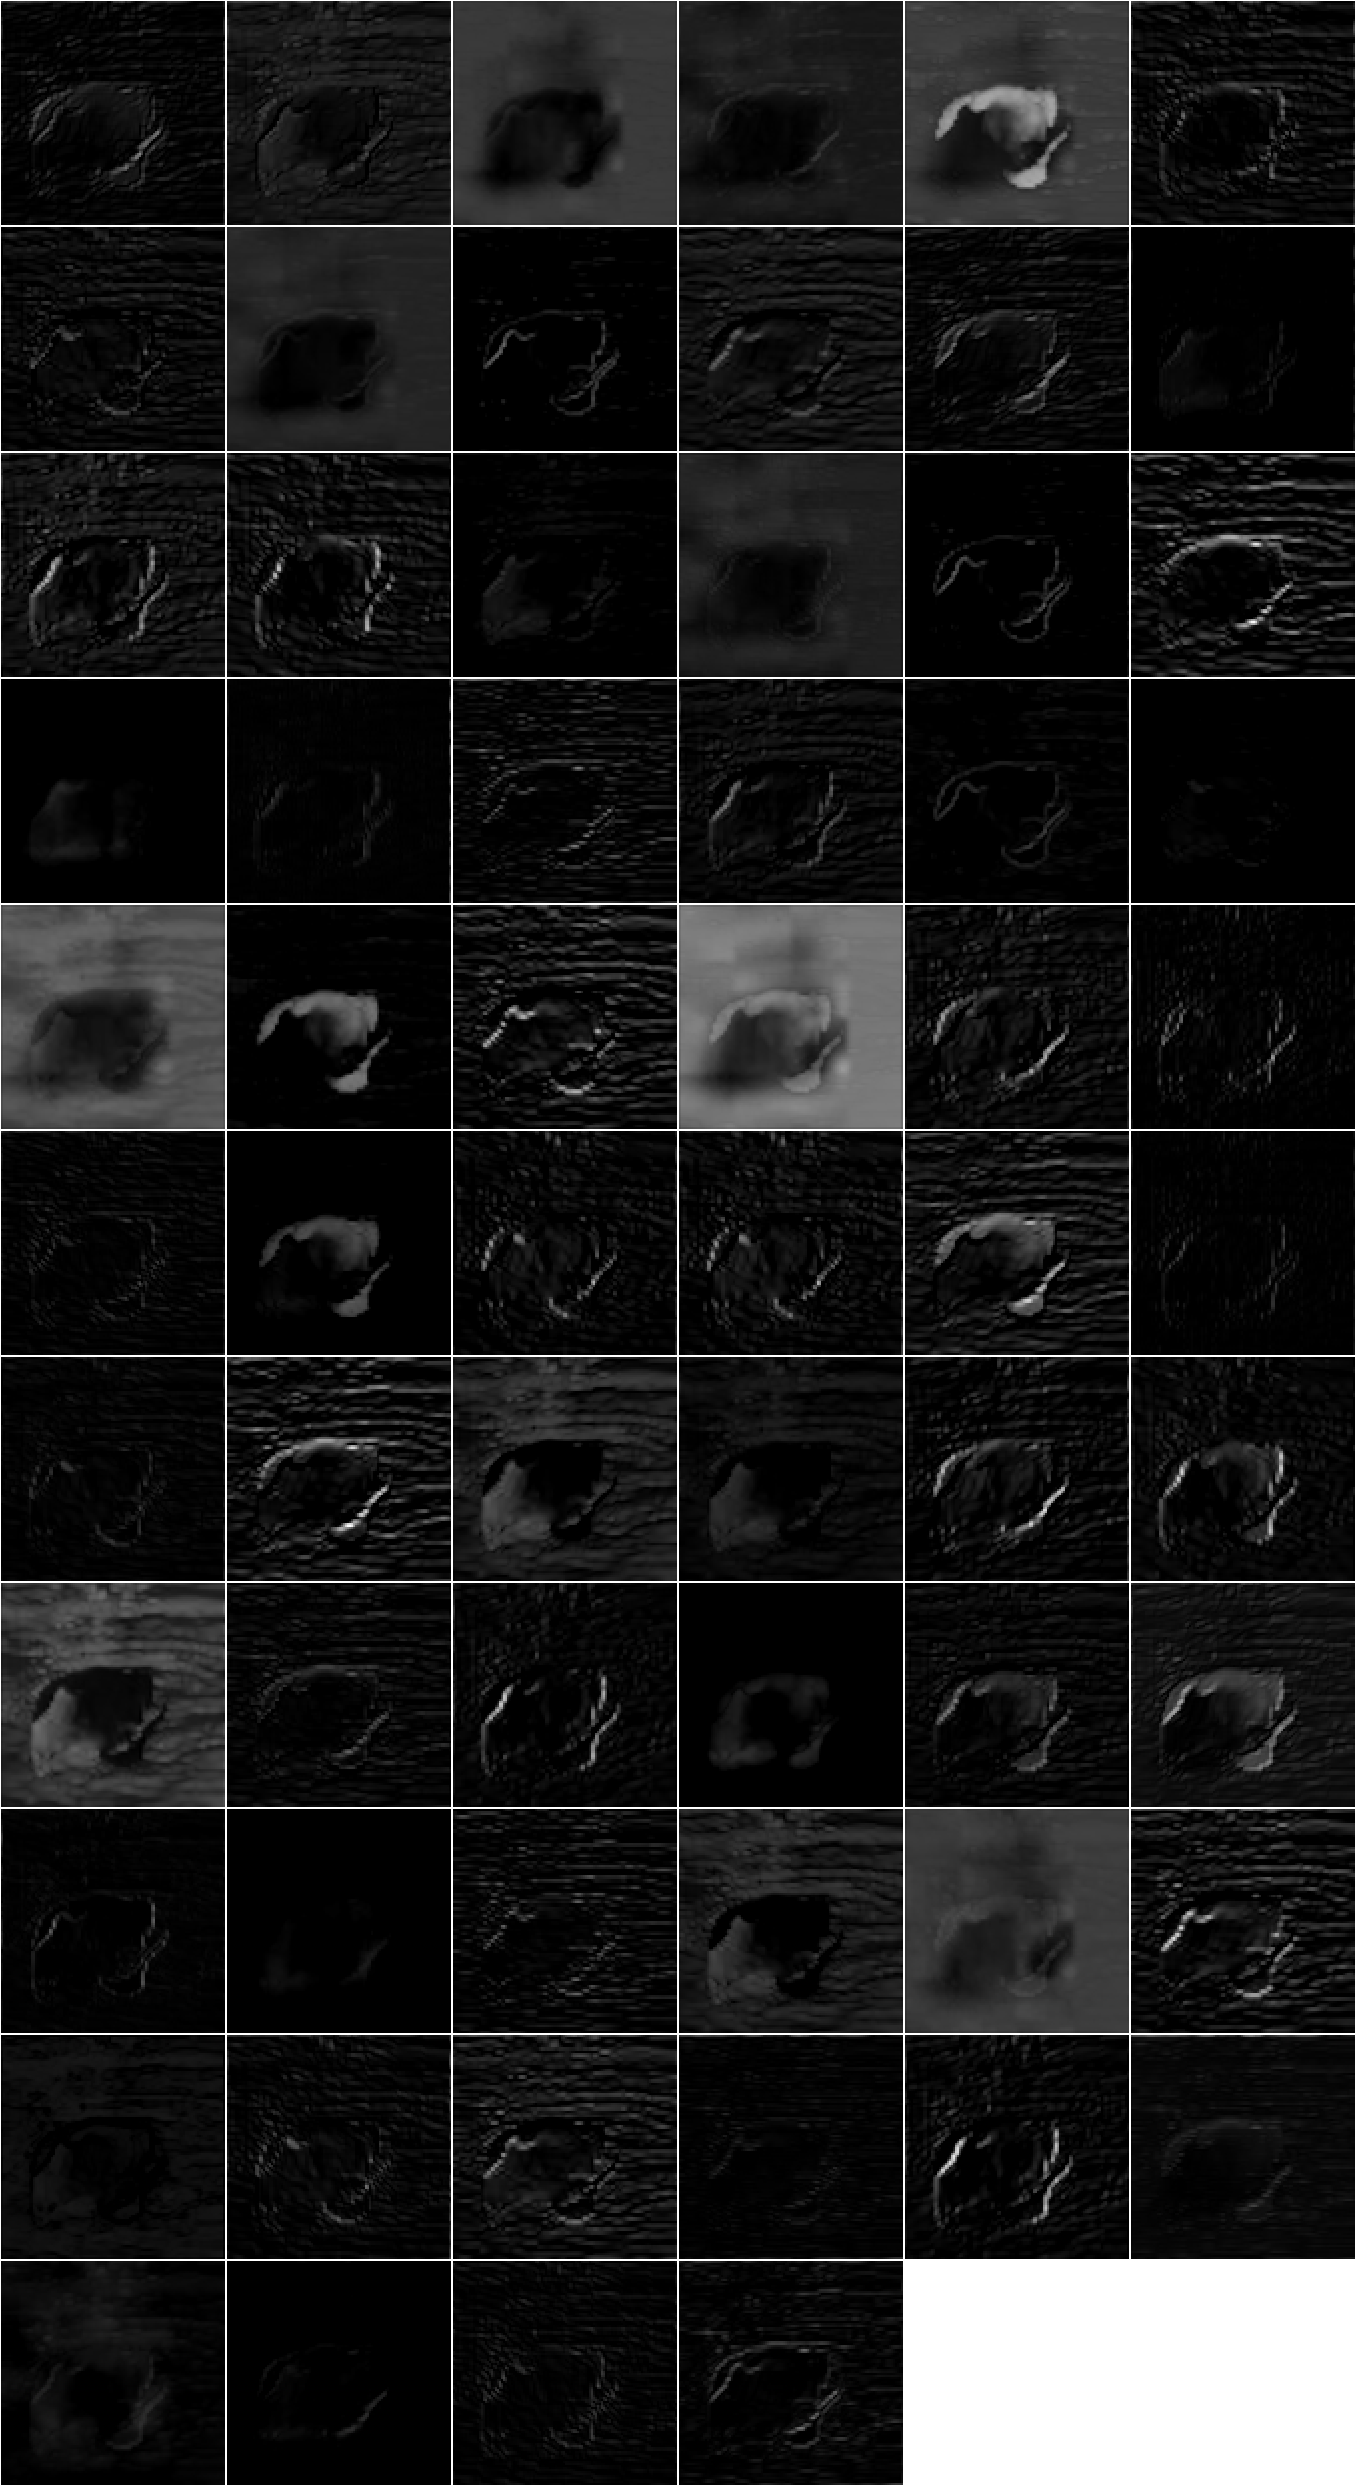

In [39]:
rescaled_layer_1 = image.scale(layer_1,224,224,'simple');
itorch.image(rescaled_layer_1)

In [40]:
-- Creating the hypercolumns
layer_1 = net.modules[5].output;
hyper_columns = image.scale(layer_1,224,224,'simple');
layer_nums = {9,16,23,30}
for i=1,3 do
    layer = net.modules[layer_nums[i]].output
    hyper_columns = torch.cat(hyper_columns,image.scale(layer,224,224,'simple'),1)
end
    

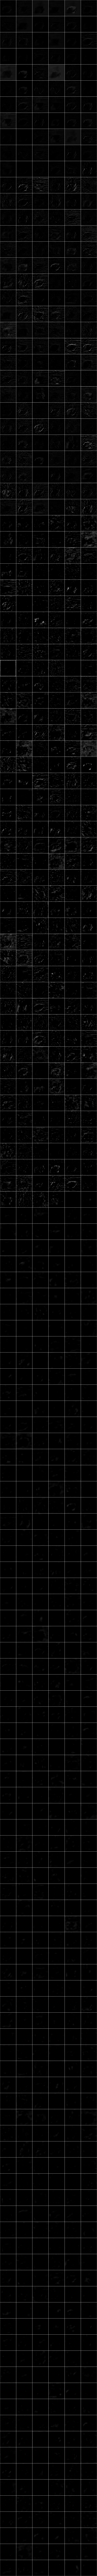

In [42]:
--itorch.image(image.scale(hyper_columns,224,224))
itorch.image(hyper_columns)

In [43]:
hyper_columns:size()

 960
 224
 224
[torch.LongStorage of size 3]

